# 项目3：人脸识别

欢迎来到机器学习工程师纳米学位的第三个项目！在此文件中，有些示例代码已经提供给你，但你还需要实现更多的功能让项目成功运行。除非有明确要求，你无须修改任何已给出的代码。每一部分都会有详细的指导，需要实现的部分也会在注释中以'TODO'标出。请仔细阅读所有的提示！

除了实现代码外，你还必须回答一些与项目和你的实现有关的问题。每一个需要你回答的问题都会以'问题 X'为标题。请仔细阅读每个问题，并且在问题后的'回答问题'文字框中写出完整的答案。我们将根据你对问题的回答和撰写代码所实现的功能来对你提交的项目进行评分。

## 任务介绍

人脸识别是一个计算机视觉任务，任务是要通过一张带有人脸的图像，对图像中的人脸进行识别并判断是谁。关于人脸识别的任务，我们一定会用到2015年Google开发的FaceNet，这个模型由于其性能非常好而被广泛使用，并且该训练好的模型已经被开源。

因此，本项目的任务将要学习人脸识别任务，在此项目中，我们将先按课程所学到的知识亲手搭建一个卷积神经网络，然后，我们将用高级的网络结构，比如ResNet50再次进行人脸识别任务，最后我们将用到预训练好的FaceNet模型。在这个过程中，我们还会用到数据增强和人脸抽取技术来提升人脸识别的精确度。

在这个人脸识别项目中，我们将使用一个开源数据集[Five Celebrity Faces Dataset](kaggle.com/dansbecker/5-celebrity-faces-dataset)，这也是一个在Kaggle比赛中的一个数据集。我们也已经下载好了并放在`./5-celebrity-faces-dataset`中，数据集中包含五位名人的照片，Ben Affleck, Elton John, Jerry Seinfeld, Madonna, Mindy Kaling。文件下分`train`和`val`。

## 数据准备
我们首先要简单的观察数据，然后通过数据增强和人脸抽取技术对数据图像数据进行抽取。你需要在完成这些操作后，思考并回答相关的问题。

### 显示一张图像

所有 train下面的图像文件名都存入 images 列表中，并将该图像的人名按顺序存于 images_name 中

In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import random

os.environ['KMP_DUPLICATE_LIB_OK']='True'

data_root = "./5-celebrity-faces-dataset/train/"

In [2]:
# TODO: 把所有 train下面的图像文件名都存入 images 列表中，并将该图像的人名按顺序存于 images_name 中
images = []
images_name = []
for imgfolder in os.listdir(data_root):
    for filename in os.listdir(data_root + imgfolder):
        filename = data_root + imgfolder + '/' + filename
        images.append(filename)
        images_name.append(imgfolder)


从`images`中随机读取一张图像，使用 `cv2.imread`读取图像，然后使用`pyplot.imshow`显示图像。注意：你需要同时显示该图像对应的人名，以及打印该图像的`shape`。

随机选取一张照片：


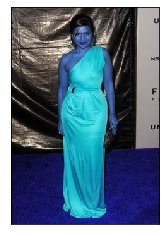

mindy_kaling
(345, 236, 3)


('./5-celebrity-faces-dataset/train/mindy_kaling/httpssmediacacheakpinimgcomxbabafeacbaaacabffjpg.jpg',
 'mindy_kaling')

In [3]:
# TODO: 从images 中随机读取一张图像，并获得该图像中的人名
def random_sample(images=images, images_name=images_name):
    print("随机选取一张照片：")
    # TODO：从 images 和 images_name 随机读取一个图像文件路径以及该图像的人名
    ind = random.randint(0,len(images))
    im_file, im_name = images[ind], images_name[ind]
    
    # TODO：使用 cv2.imread 读取图像文件
    img = cv2.imread(im_file)
    # TODO：使用 plt.imshow 和 plt.show() 显示图像
    plt.imshow(img)
    plt.xticks([]), plt.yticks([])
    plt.show()
    
    # 打印该图像的人名
    print(im_name)
    # 打印该图像的大小 shape
    print(img.shape)
    return im_file, im_name

random_sample(images, images_name)

你可以多次运行上面的代码来多观察一些人物图像，以此来对数据有一个大致的认知

用`cv2.imread`读取所有数据并存入`train_x`中，然后用 0,1,2,3,4 来标记 Ben Affleck, Elton John, Jerry Seinfeld, Madonna, Mindy Kaling，并将所有`images_name`数据存入`train_y`中。

### 数据增强

首先，我们需要打印训练集的数量。

In [4]:
print(len(images))

93


我们可以看到，训练集的图像数量比较少，这对模型建模并学习图像数据到人名标签的映射关系增加了难度，所以这里需要做数据增强的工作。这里有一份很不错的资料可以帮助你了解数据增强——[Data Augmentation](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)。


In [5]:
from keras.preprocessing.image import ImageDataGenerator

# TODO: 构造图像数据增强器

data_gen = ImageDataGenerator(
    rescale = 1./255, # TODO：随机缩放图像RGB值的倍数
    rotation_range = 40, # TODO：随机旋转图像的范围
    zoom_range = [0.5, 1.0],  # TODO：随机缩放图像大小范围
    width_shift_range = [-10,10],  # TODO：随机水平方向平移图像(fraction of total width)
    height_shift_range= 0.5  # TODO：随机纵向平移图像(fraction of total height)
)

Using TensorFlow backend.


使用 `flow_from_directory` 遍历数据集 `./5-celebrity-faces-dataset/data`，来观察数据增强的表现。先得到一个图像迭代器，该迭代器每次都从路径里读取一个图像，并按照数据增强器的规则进行编辑图像

In [6]:
# 直接运行，得到一个图像迭代器，该迭代器每次都从路径里读取一个图像，并按照数据增强器的规则进行编辑图像
dataflow_generator = data_gen.flow_from_directory(
    "./5-celebrity-faces-dataset/data",
    target_size=(160, 160),
    batch_size=1,
    class_mode='categorical')

Found 5 images belonging to 5 classes.


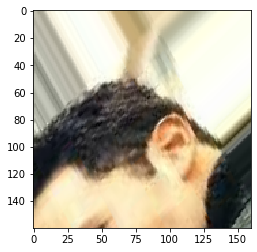

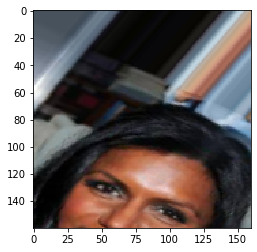

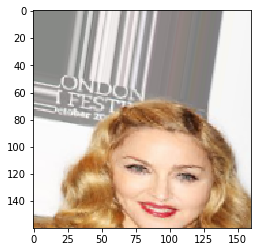

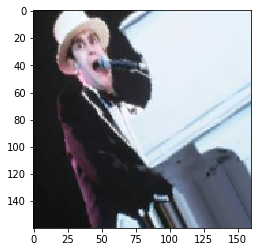

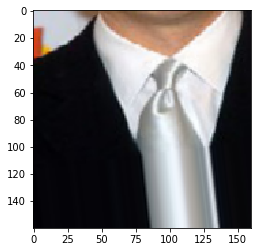

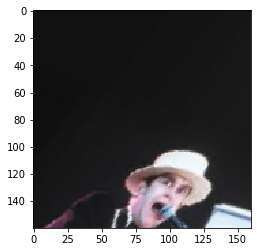

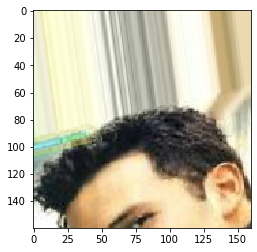

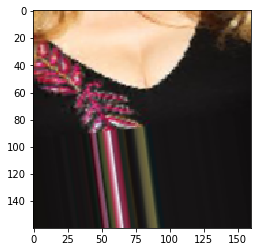

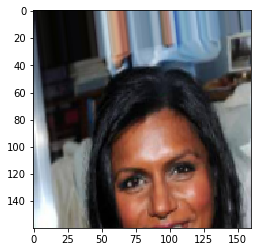

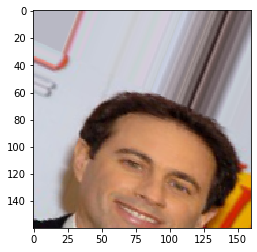

In [7]:
# TODO：从 迭代器中 读取10张图片，并显示图像

sample_count = 10
for image_data in dataflow_generator:
    # TODO：使用 plt.imshow 和 plt.show() 显示图像
    plt.imshow(image_data[0][0])
    plt.show()
    sample_count -= 1
    if sample_count <= 0:
        break
        

**问题1**：观察以上人脸图像，简单说说产生的图像中存在哪些增强的部分，然后再详细阐述你对数据增强的思考，包括为什么数据增强能够帮助人脸识别？你需要参考一些论文，并列出你的引用。

**问题回答：** 以上产生的人脸图像发生了逆时针旋转，图像缩小，向左向上平移等增强的部分，无法肉眼观察到RGB缩放效果。

深度神经网络相比于传统模型的优势在于数据量越大，模型的预测性能越好（参考下图）--Andrew Ng。
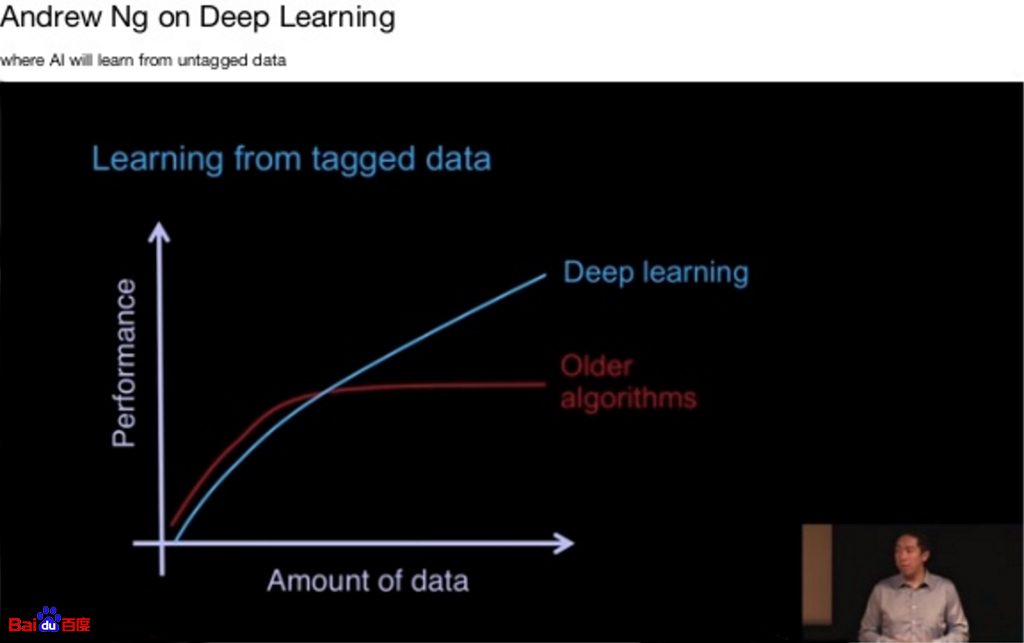

数据增强是一种从现有训练数据中人工创建新训练数据的技术，它是在训练集中创建于原始图像属于同一类的图像的转换版本，转换包括平移、翻转、缩放等操作。训练集中的同一张人脸可以通过数据增强技术产生多种变体，这样一来，数据增强增加了数据量和多样性，神经网络也可以从中更好地学习，从而增强神经网络的泛化能力帮助人脸识别。

ImageDataGenerator类常用的参数有：

zca_epsilon=1e-06, # 应用ZCA白化 epsilon 值。常用。

rotation_range=0,# 整数。随机旋转的度数范围。常用。

zoom_range = 0.1, # 随机缩放图像大小

width_shift_range=0.1, # 随机水平方向平移图像(fraction of total width)

height_shift_range=0.1, # 随机纵向平移图像(fraction of total height)

horizontal_flip= True,# 水平翻转，常用。

rescale=1./255,# 数据缩放，常用:1/255.0。

validation_split=0.0,# 验证集划分。常用。


[参考1: How to Configure Image Data Augmentation in Keras](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)

[参考2: AutoAugment:Learning Augmentation Strategies from Data](https://arxiv.org/pdf/1805.09501v3.pdf)

[参考3: ImageNet Classification with Deep Convolutional
Neural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)

[参考4: 图片数据集太少？看我七十二变](https://zhuanlan.zhihu.com/p/30197320)

[参考5: N维图像的数据增强方法概览](https://zhuanlan.zhihu.com/p/37139729)

[参考6: Keras ImageDataGenerator 图像数据扩充参数说明](https://www.jianshu.com/p/4c7795af350b)

### 人脸抽取

在做人脸识别任务中，一项常用的图像数据处理的技术是人脸检测（Face Detection）。人脸检测是将输入的图片中的人脸部分自动检测出来，具体来说就是要通过预测一个矩形边界框（Bounding Box）从整个图像中定位人脸部分，这里的矩形边界框由矩形左下角坐标以及矩形高和宽来定义。人脸检测是一个比较成熟的任务，接下来在我们这个项目中，我们将使用 Multi-Task Cascaded Convolutional Neural Network，MTCNN，你也可以参考论文：[Joint Face Detection and Alignment Using Multitask Cascaded Convolutional Networks](https://arxiv.org/abs/1604.02878)，来学习人脸检测任务。

In [8]:
# 运行下面代码，安装 mtcnn
# !pip install mtcnn

随机选取一张照片：


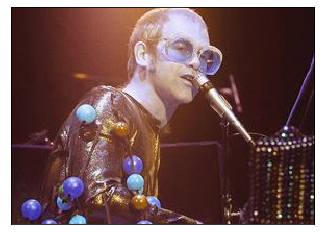

elton_john
(209, 292, 3)












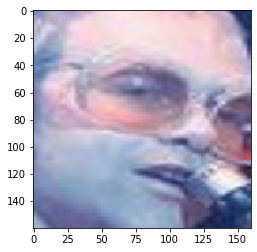

(160, 160, 3)


In [9]:
# 定义人脸抽取的函数
from PIL import Image
from mtcnn.mtcnn import MTCNN
import numpy as np

def extract_face(filename, image_size=(160, 160)):
    # 加载图像
    image = Image.open(filename)
    # 转换RGB
    image = image.convert('RGB')
    # 转成 numpy.array 格式的数据
    image_data = np.asarray(image)
    # 创建一个人脸检测，
    detector = MTCNN()
    # 从图像中检测
    results = detector.detect_faces(image_data)
    # 返回的结果是图像中所有出现的人脸的矩形边界框，由于我们的图像中只有一张人脸，所所以只需要取结果中第一个
    box_x, box_y, width, height = results[0]['box']
    # 处理下标为负的情况
    box_x, box_y = abs(box_x), abs(box_y)
    box_x_up, box_y_up = box_x + width, box_y + height
    # 获得人脸部分的数据
    face = image_data[box_y:box_y_up, box_x:box_x_up]
    #print(face.shape)
    # TODO：把抽取出来的人脸图像 resize 至需要的图像大小，并返回numpy格式的数据
    face_array = cv2.resize(face, image_size)
    return face_array

ran_img_file, ran_img_name = random_sample()
img = extract_face(ran_img_file)
plt.imshow(img)
plt.show()
print(img.shape)

**问题2：**通过多次运行以上代码并观察人脸抽取后的图像，你认为人脸检测对人脸识别有帮助吗？为什么？你需要参考一些论文，并列出你的reference。

**回答问题：** 有帮助。抽取出人脸之后，大大降低了noise，增强了人脸feature在人脸识别中的作用。

https://zhuanlan.zhihu.com/p/58825924；https://zhuanlan.zhihu.com/p/36621308

### 构造数据

现在我们可以应用以上的数据增强和人脸检测技术来构造完整的数据。

这里可以直接使用前面定义好的图像数据增强器 `data_gen`，然后使用 [ImageDataGenerator](https://keras.io/preprocessing/image/)中的 `random_transform` 对单个图像做随机增强操作。

另外，在构造数据之前，你需要先构造一个人名到类别的映射，使得在构造数据的label的时候将string格式的人名转换为int格式的类别。

编程练习：
1. 你需要 构造人名字典，将 ben_afflek、elton_john、jerry_seinfeld、madonna、mindy_kaling 分别映射到 0-1-2-3-4
2. 定义 `load_dataset`函数，遍历train或者val文件夹，读取文件夹下5个人名文件夹，以该文件夹名映射至0到4 的标签；然后分别从人名文件夹中遍历所有图像文件，读取图像，如果是train文件夹下的图像，则需要用`data_gen.random_transform`来增强图像数据，增强次数为augment_times；如果是val文件夹下的图像，则不需要进行图像增强

In [10]:
# TODO：构造人名字典，将 ben_afflek、elton_john、jerry_seinfeld、madonna、mindy_kaling 分别映射到 0-1-2-3-4
name_dict = {
    'ben_afflek': 0,
    'elton_john': 1,
    'jerry_seinfeld': 2,
    'madonna': 3,
    'mindy_kaling': 4
}

# TODO：定义数据加载函数，data_dir为文件路径，augment_times为数据增强次数，is_train为判断是训练集还是测试集（测试集不需要数据增强）
def load_dataset(data_dir = "./5-celebrity-faces-dataset/train/", augment_times=2, is_train=True):
    data_x = []
    data_y = []
    # TODO:
    
    for imgfolder in os.listdir(data_dir):
        for imgname in os.listdir(data_dir + imgfolder):
            imgname = data_dir + imgfolder + '/' + imgname
            try:
                image = extract_face(imgname)
            except:
                print('No such file exists!')
            if is_train:
                image_dict = name_dict[imgfolder]
                while augment_times > 0:
                    data_gen.random_transform(image)
                    augment_times -= 1
            else:
                image_dict = name_dict[imgfolder]
                
            data_x.append(image)
            data_y.append(image_dict)

    return data_x, data_y

train_x, train_y = load_dataset("./5-celebrity-faces-dataset/train/", augment_times=2, is_train=True)
test_x, test_y = load_dataset("./5-celebrity-faces-dataset/val/", is_train=False)

# 最终构造好训练和测试数据
train_X = np.asarray(train_x)
train_Y = np.eye(5)[np.array(train_y)]
test_X = np.asarray(test_x)
test_Y = np.eye(5)[np.array(test_y)]

### 构建一个卷积神经网络

创建一个卷积神经网络来对人脸进行分类。在你代码块的最后，执行 `model.summary()` 来输出你模型的总结信息。
。

![Sample CNN](images/sample_cnn.png)

**问题3：**在下方的代码块中尝试使用 Keras 搭建卷积网络的架构，并回答相关的问题。

1. 你可以尝试自己搭建一个卷积网络的模型，那么你需要回答你搭建卷积网络的具体步骤（用了哪些层）以及为什么这样搭建。
2. 你也可以根据上图提示的步骤搭建卷积网络，那么请说明如上的架构能够在该问题上取得的表现。


**回答问题：**

In [11]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: 定义你的网络架构

## 第一层卷积层
model.add(Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', input_shape=train_X.shape[1:]))
## 构建第一层最大池化层
model.add(MaxPooling2D(pool_size=(2,2)))
## Dropout
model.add(Dropout(0.25))

## 第二层卷积层
model.add(Conv2D(32,(3,3),activation='relu'))
## 构建第二层最大池化层
model.add(MaxPooling2D(pool_size=(2,2)))
## Dropout
model.add(Dropout(0.25))

## 第三层卷积层
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(GlobalAveragePooling2D(data_format=None))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))

model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1429 (Conv2D)         (None, 158, 158, 32)      896       
_________________________________________________________________
max_pooling2d_715 (MaxPoolin (None, 79, 79, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_1430 (Conv2D)         (None, 77, 77, 32)        9248      
_________________________________________________________________
max_pooling2d_716 (MaxPoolin (None, 38, 38, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 38, 38, 32)        0         
__________________________

In [12]:
# 直接运行编译模型和训练模型

# 编译模型
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# 模型训练
model.fit(train_X, train_Y, batch_size=8, epochs=50)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
93/93 [==============================] - ETA: 0s - loss: 13.1875 - acc: 0.18 - 11s 117ms/step - loss: 13.1718 - acc: 0.1828
Epoch 2/50
93/93 [==============================] - 1s 15ms/step - loss: 13.1718 - acc: 0.1828
Epoch 3/50
93/93 [==============================] - 1s 15ms/step - loss: 13.1718 - acc: 0.1828
Epoch 4/50
93/93 [==============================] - 1s 15ms/step - loss: 13.1718 - acc: 0.1828
Epoch 5/50
93/93 [==============================] - 1s 15ms/step - loss: 13.1718 - acc: 0.1828
Epoch 6/50
93/93 [==============================] - 1s 15ms/step - loss: 13.1718 - acc: 0.1828
Epoch 7/50
93/93 [==============================] - 1s 15ms/step - loss: 13.1718 - acc: 0.1828
Epoch 8/50
93/93 [==============================] - 1s 15ms/step - loss: 13.1718 - acc: 0.1828
Epoch 9/50
93/93 [==============================] - 1s 15ms/step - loss: 13.1718 - acc: 0.1828
Epoch 1

#### 模型测试

你需要编写一个自动测试模型准确率的函数。

In [13]:
def metric_accuracy(model, test_X, test_Y, model_name):
    preds_Y = model.predict(test_X)
    #TODO：通过预测值preds_Y以及真实值test_Y，来计算准确率
    
    model_predictions = [np.argmax(x) for x in preds_Y]
    accuracy = np.sum(np.array(model_predictions) == np.argmax(test_Y, axis=1))/len(preds_Y)
    
    print("%s Accuracy: %.3f" % (model_name, accuracy))
    
metric_accuracy(model, test_X, test_Y, "Simple CNN")

Simple CNN Accuracy: 0.200


In [14]:
score = model.evaluate(test_X, test_Y, verbose=0)
print(score[1])

0.20000000298023224


### 进阶 CNN 模型架构
在计算机视觉任务中，有一些复杂的高级CNN模型架构，比如ResNet、VGG、Inception 等等，他们能够对图像有一个非常好的表达。并且，已经有人把这些模型在非常大的图像数据上训练好了参数，这使得预训练的大模型能够对图像有一个很好的特征表达。这种在大规模图像数据上学到的图像特征，能够迁移到人脸图像的特征表示。

在这一小节，我们利用预训练好的 ResNet50,抽取图像特征，然后再去做人脸识别。虽然 ResNet50 在各种图像上面进行预训练的，但是该模型对图像结构特征信息的学习也能够帮助人脸识别任务中的预测。


In [15]:
import keras 
from keras.models import Model, Sequential

# 模型底层使用 ResNet50 对原始图像进行建模，特征抽取
resnet50_weights = "./models/resnet50_weights.h5"
resnet = keras.applications.resnet50.ResNet50(weights=None, include_top=False, input_shape=(160, 160, 3))
resnet.load_weights(resnet50_weights)

# TODO：自己定义模型顶层，使用抽取后的特征进行人脸识别
resnet_face = Sequential()
resnet_face.add(Flatten(input_shape=resnet.output_shape[1:]))
resnet_face.add(Dense(5, activation = 'softmax'))

resnet_face_model = Model(inputs=resnet.input, outputs=resnet_face(resnet.output))
resnet_face_model.summary()

import keras 
from keras.models import Model, Sequential

# 模型底层使用 ResNet50 对原始图像进行建模，特征抽取
resnet50_weights = "./models/resnet50_weights.h5"
resnet = keras.applications.resnet50.ResNet50(weights=None, include_top=False, input_shape=(160, 160, 3))
resnet.load_weights(resnet50_weights)

# TODO：自己定义模型顶层，使用抽取后的特征进行人脸识别
resnet_face = Sequential()
resnet_face.add(Flatten(input_shape=resnet.output_shape[1:]))
resnet_face.add(Dense(5, activation = 'softmax'))


resnet_face_model = Model(inputs=resnet.input, outputs=resnet_face(resnet.output))
resnet_face_model.summary()


/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_358 (InputLayer)          (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 3)  0           input_358[0][0]                  
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 80, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 80, 80, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_359 (InputLayer)          (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 3)  0           input_359[0][0]                  
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 80, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 80, 80, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [16]:
# 设置同样的训练参数，直接运行

## 编译模型
resnet_face_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# 模型训练
resnet_face_model.fit(train_X, train_Y, batch_size=8, epochs=50)

Epoch 1/50
93/93 [==============================] - 48s 514ms/step - loss: 6.2732 - acc: 0.2688
Epoch 2/50
93/93 [==============================] - 14s 155ms/step - loss: 2.8283 - acc: 0.5269
Epoch 3/50
93/93 [==============================] - 14s 155ms/step - loss: 2.2671 - acc: 0.6344
Epoch 4/50
93/93 [==============================] - 14s 155ms/step - loss: 2.3705 - acc: 0.6237
Epoch 5/50
93/93 [==============================] - 15s 164ms/step - loss: 1.9836 - acc: 0.7097
Epoch 6/50
93/93 [==============================] - 16s 176ms/step - loss: 3.0037 - acc: 0.5054
Epoch 7/50
93/93 [==============================] - 15s 160ms/step - loss: 3.0237 - acc: 0.6559
Epoch 8/50
93/93 [==============================] - 16s 169ms/step - loss: 2.2149 - acc: 0.6882
Epoch 9/50
93/93 [==============================] - 15s 160ms/step - loss: 2.9039 - acc: 0.6882
Epoch 10/50
93/93 [==============================] - 16s 168ms/step - loss: 2.4406 - acc: 0.7419
Epoch 11/50
93/93 [====================

模型测试

In [17]:
# 直接运行，测试 resnet_face_model 的准确率
metric_accuracy(resnet_face_model, test_X, test_Y, "ResNet50")


ResNet50 Accuracy: 0.560


**问题5：**对比 ResNet50 模型和 CNN 模型的结果，请你分析为什么 ResNet50 模型能够取得更好的结果？

**回答问题：**
ResNet50可以进行残差学习，残差学习相对更容易，从直观上看残差学习需要学习的内容少，因为残差一般会比较小，学习难度小点，可以训练比CNN深度更大的网络。

https://zhuanlan.zhihu.com/p/31852747

**问题6：**上面我们使用了预训练好的 ResNet50，即`resnet.load_weights(resnet50_weights)`，那么加载预训练好的参数对该任务有帮助吗？你需要通过做对比实验，即不加载预训练好的参数，然后在下面的代码框中重新跑一遍 ResNet50 的模型，来作为对比说明加载预训练是否有帮助

**回答问题：** 有帮助，加载预训练好的参数的准确率是0.56，大于不加载预训练好的参数的准确率。

In [19]:
# 重新跑一遍不加载预训练参数的 ResNet50 的模型，请在此处写完整的code


import keras 
from keras.models import Model, Sequential

# 模型底层使用 ResNet50 对原始图像进行建模，特征抽取
resnet50_weights = "./models/resnet50_weights.h5"
resnet = keras.applications.resnet50.ResNet50(weights=None, include_top=False, input_shape=(160, 160, 3))
#resnet.load_weights(resnet50_weights)

# TODO：自己定义模型顶层，使用抽取后的特征进行人脸识别
resnet_face = Sequential()
resnet_face.add(Flatten(input_shape=resnet.output_shape[1:]))
resnet_face.add(Dense(5, activation = 'softmax'))


resnet_face_model = Model(inputs=resnet.input, outputs=resnet_face(resnet.output))
#resnet_face_model.summary()

# 设置同样的训练参数，直接运行

## 编译模型
resnet_face_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# 模型训练
resnet_face_model.fit(train_X, train_Y, batch_size=8, epochs=50)

# 直接运行，测试 resnet_face_model 的准确率
metric_accuracy(resnet_face_model, test_X, test_Y, "ResNet50")


/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/50
93/93 [==============================] - 53s 568ms/step - loss: 12.3249 - acc: 0.1720
Epoch 2/50
93/93 [==============================] - 14s 154ms/step - loss: 13.1718 - acc: 0.1828
Epoch 3/50
93/93 [==============================] - 14s 155ms/step - loss: 13.1718 - acc: 0.1828
Epoch 4/50
93/93 [==============================] - 14s 156ms/step - loss: 13.1718 - acc: 0.1828
Epoch 5/50
93/93 [==============================] - 14s 154ms/step - loss: 13.1718 - acc: 0.1828
Epoch 6/50
93/93 [==============================] - 14s 154ms/step - loss: 13.1718 - acc: 0.1828
Epoch 7/50
93/93 [==============================] - 14s 154ms/step - loss: 13.1718 - acc: 0.1828
Epoch 8/50
93/93 [==============================] - 15s 160ms/step - loss: 13.1718 - acc: 0.1828
Epoch 9/50
93/93 [==============================] - 15s 161ms/step - loss: 13.1718 - acc: 0.1828
Epoch 10/50
93/93 [==============================] - 15s 158ms/step - loss: 13.1718 - acc: 0.1828
Epoch 11/50
93/93 [==========

### FaceNet 

上一小节中，我们利用了预训练好的 ResNet50 来抽取图像特征，而这一小节我们将利用预训练好的 FaceNet 来抽取人脸特征。我们已经知道 ResNet50 是在大规模数据上建模学习图像特征的，这里面的数据是多种多样的，不限制于人脸图像，而 [FaceNet](https://arxiv.org/pdf/1503.03832.pdf) 是专门对于人脸进行特征抽取的工具。

In [20]:
# TODO：使用 load_model 从`./models/facenet_keras.h5` 加载模型
from keras.models import load_model

# 模型底层使用 FaceNet 对原始图像进行建模，特征抽取
# 加载预训练好的 FaceNet 模型。
facenet_model = load_model('./models/facenet_keras.h5')
print("FaceNet model loaded...")

# TODO：自己定义模型顶层，使用抽取后的特征进行人脸识别
facenet_face = Sequential()
facenet_face.add(Dense(5, activation = 'softmax'))


facenet_face_model = Model(inputs=facenet_model.input, outputs=facenet_face(facenet_model.output))
facenet_face_model.summary()


FaceNet model loaded...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
_____________________________________________________________________________________

/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [21]:
train_XX = []
for x in train_X:
    x_image = Image.fromarray(x)
    x_image = x_image.resize((160, 160))
    train_XX.append(np.asarray(x_image))
train_X = np.array(train_XX)
train_X[0].shape

(160, 160, 3)

In [22]:
## 编译模型
facenet_face_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# 模型训练
facenet_face_model.fit(train_X, train_Y, batch_size=8, epochs=50)

Epoch 1/50
93/93 [==============================] - 66s 713ms/step - loss: 0.7504 - acc: 0.7097
Epoch 2/50
93/93 [==============================] - 11s 123ms/step - loss: 0.5523 - acc: 0.7957
Epoch 3/50
93/93 [==============================] - 11s 122ms/step - loss: 0.3672 - acc: 0.8602
Epoch 4/50
93/93 [==============================] - 11s 121ms/step - loss: 0.3753 - acc: 0.9032
Epoch 5/50
93/93 [==============================] - 11s 121ms/step - loss: 0.2847 - acc: 0.9032
Epoch 6/50
93/93 [==============================] - 11s 122ms/step - loss: 0.1369 - acc: 0.9355
Epoch 7/50
93/93 [==============================] - 11s 122ms/step - loss: 0.1762 - acc: 0.9570
Epoch 8/50
93/93 [==============================] - 12s 125ms/step - loss: 0.2079 - acc: 0.9462
Epoch 9/50
93/93 [==============================] - 13s 136ms/step - loss: 0.5117 - acc: 0.8280
Epoch 10/50
93/93 [==============================] - 12s 127ms/step - loss: 0.1951 - acc: 0.9247
Epoch 11/50
93/93 [====================

In [23]:
test_XX = []
for x in test_X:
    x_image = Image.fromarray(x)
    x_image = x_image.resize((160, 160))
    test_XX.append(np.asarray(x_image))
test_X = np.array(test_XX)
test_X[0].shape

preds_Y = facenet_face_model.predict(test_X)
correct = 0.
for pr, y in zip(preds_Y, test_Y):
    pr_cls = np.argmax(pr)
    if y[pr_cls] == 1:
        correct += 1
accuracy = correct / len(preds_Y)
print("FaceNet Accuracy: %.3f" % accuracy)

FaceNet Accuracy: 0.920


**问题7：**评价 FaceNet 模型的效果，并指出为什么 FaceNet 比上一小节中 ResNet 的效果要好。

**回答问题：**
FaceNet可以从人脸中提取出高质量的特征，直接将人脸图像嵌入欧几里得空间的映射。它只需要对图片进行很少量的处理（只需要裁剪脸部区域，而不需要额外预处理，比如3d对齐等），即可作为模型输入。同时，该模型在数据集上准确率非常高。

https://zhuanlan.zhihu.com/p/24837264

**问题8：**
- 首先你需要在下放画一个表格，将上面所做的实验结果都列出来。
- 然后总结此项目，你认为在这个**人脸识别**项目中，哪些技术对识别准确率起比较重要的作用？请结合以上的实验结果分析。
- 最后，你再简要说说还有哪些技术对人脸识别任务有较大的帮助？列出你的references

**回答问题：**
实验结果总结

|Models|Accuracy|
|---|---|
|CNN|0.20|
|ResNet50 no-pretrain|0.20|
|ResNet50 pretrain|0.56|
|FaceNet|0.92|

在这个**人脸识别**项目中，人脸抽取技术，数据增强和FaceNet技术对识别准确率起比较重要的作用；

此外，DeepFace，DeepID，FR+FCN，pose+shape+expression augmentation和CNN-3DMM estimation等技术都对人脸识别任务有较大的帮助。
前两种方法的核心是搜集大数据，通过更多更全的数据集让模型学会去识别人脸的多样性； 后三种方法方法采用的是合成的思路，通过3D模型等合成不同类型的人脸，增加数据集。这类方法操作成本更低，更适合推广。其中，CNN-3DMM estimation的作者提供了源码，可以进一步参考和深度研究。

https://zhuanlan.zhihu.com/p/24816781